In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


class TrafficSignDetector:
    def __init__(self, images_dir, train_images_dir):
        """
        Initialize the TrafficSignDetector with directories for images.

        :param images_dir: Path to the root image directory
        :param train_images_dir: Path to the training images subdirectory
        """
        self.images_dir = images_dir
        self.train_images_dir = train_images_dir

        # Placeholder for image dimensions and processing steps
        self.height = None
        self.width = None
        self.gray_image = None
        self.histofram_eq_image = None
        self.blurred_image = None
        self.thresholded_image = None
        self.edges = None
        self.eroded_image = None
        self.filtered_components = None
        self.output_image = None
        self.circles = None
        self.detected_plates = []

    def process_image(self, image_name):
        """
        Process an image through the detection pipeline.
        
        :param image_name: Filename of the image to process
        """
        # 1. Load and convert to grayscale
        image_path = os.path.join(self.images_dir, self.train_images_dir, image_name)
        self.gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        self.height, self.width = self.gray_image.shape
        

        # 2. Gaussian blur
        kernel_size = (self.width // 50, self.height // 50)  # Relative kernel size
        kernel_size = (max(3, kernel_size[0] | 1), max(3, kernel_size[1] | 1))  # Ensure odd size
        self.blurred_image = cv2.GaussianBlur(self.gray_image, kernel_size, 0)

        

        # 3. Thresholding
        self.thresholded_image = cv2.adaptiveThreshold(
                self.blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2
                )

        
        # 4. Edge detection
        edge_threshold1 = 100
        edge_threshold2 = 200
        self.edges = cv2.Canny(self.thresholded_image, edge_threshold1, edge_threshold2)

        # 5. Morphological operations
        kernel_size = (self.width // 80, self.height // 80)  # Relative kernel size
        kernel_size = (max(3, kernel_size[0]), max(3, kernel_size[1]))  # Ensure minimum size
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        dilated_image = cv2.dilate(self.edges, kernel, iterations=1)
        self.eroded_image = cv2.erode(dilated_image, kernel, iterations=1)


        # 6. Circle detection (Hough Transform)
        min_radius = min(self.height // 5, self.width // 5)  # Relative to image height
        max_radius = max(self.height // 2, self.width // 2)
        self.circles = cv2.HoughCircles(
            self.eroded_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=min(self.height // 5, self.width // 5),
            param1=50,
            param2=30,
            minRadius=min_radius,
            maxRadius=max_radius,
        )

        # 7. Remove overlapping circles
        #self.remove_overlapping_circles()

        # 8. Draw detected circles and extract plates
        self.output_image = cv2.cvtColor(self.gray_image, cv2.COLOR_GRAY2BGR)
        if self.circles is not None:
            self.circles = np.uint16(np.around(self.circles))
            for circle in self.circles[0, :]:
                x, y, r = circle
                cv2.circle(self.output_image, (x, y), r, (0, 255, 0), 2)
                cropped_plate = self.gray_image[max(0, y - r) : min(self.height, y + r), max(0, x - r) : min(self.width, x + r)]
                self.detected_plates.append(cropped_plate)

    def remove_overlapping_circles(self, overlap_threshold=0.3):
        """
        Remove overlapping circles from the list based on a threshold.

        :param overlap_threshold: The minimum overlap ratio to consider two circles as overlapping
        """
        if self.circles is not None:
            valid_circles = []
            for i, circle1 in enumerate(self.circles[0, :]):
                x1, y1, r1 = circle1
                is_overlapping = False
                
                # If valid_circles is empty, we can add the first circle directly
                if len(valid_circles) == 0:
                    valid_circles.append(circle1)
                    continue
                
                for circle2 in valid_circles:
                    x2, y2, r2 = circle2
                    # Calculate distance between centers
                    distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                    print(x1, y1, r1, x2, y2, r2, distance)
                    # Check if the circles overlap more than the threshold
                    print(distance, (r1 + r2) * (1 - overlap_threshold))
                    if distance < (r1 + r2) * (1 - overlap_threshold):
                        is_overlapping = True
                        break

                if not is_overlapping:
                    valid_circles.append(circle1)
            
            # Update self.circles with the filtered non-overlapping circles
            self.circles = np.array([valid_circles], dtype=np.uint16)


    def visualize_results(self):
        """
        Visualize intermediate results and detected plates.
        """
        titles = [
            "Original Image",
            "Gaussian Blur",
            "Thresholded Image",
            "Edges",
            "Morphological Image",
            "Detected Circles",
        ]
        images = [
            self.gray_image,
            self.blurred_image,
            self.thresholded_image,
            self.edges,
            self.eroded_image,
            self.output_image,
        ]

        plt.figure(figsize=(20, 10))
        for i, (title, img) in enumerate(zip(titles, images), 1):
            if img is not None:
                plt.subplot(2, 4, i)
                plt.title(title)
                cmap = "gray" if len(img.shape) == 2 else None
                plt.imshow(img, cmap=cmap)
                #plt.axis("off")

        # Visualize detected plates
        for i, plate in enumerate(self.detected_plates, 1):
            plt.figure(figsize=(5, 5))
            plt.title(f"Detected Plate {i}")
            plt.imshow(plate, cmap="gray")
            #plt.axis("off")
            plt.show()

        plt.tight_layout()
        plt.show()


libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
/var/folders/ps/w20y7l6s0czd7vj9t9xzwbbc0000gn/T/ipykernel_70343/197802723.py:94: RuntimeWarning: overflow encountered in scalar subtract
  cropped_plate = self.gray_image[max(0, y - r) : min(self.height, y + r), max(0, x - r) : min(self.width, x + r)]


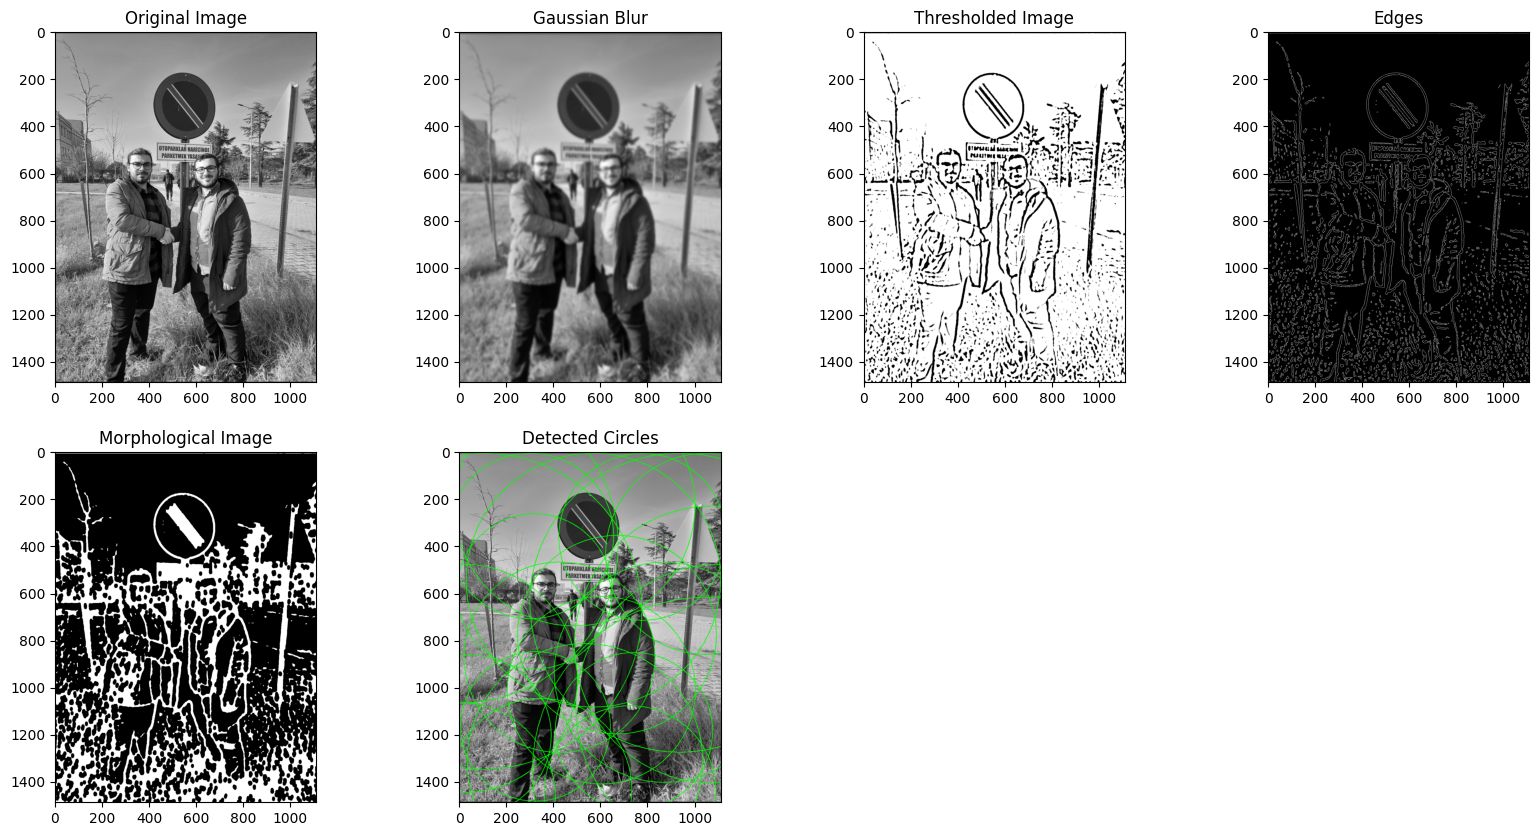

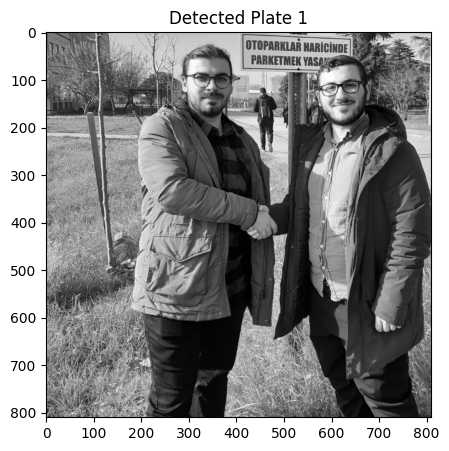

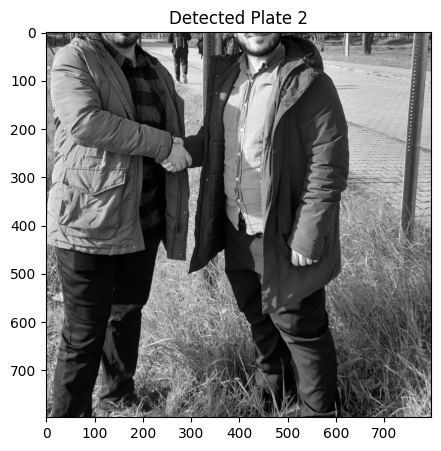

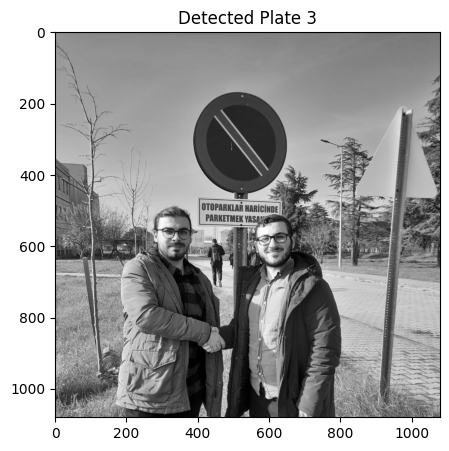

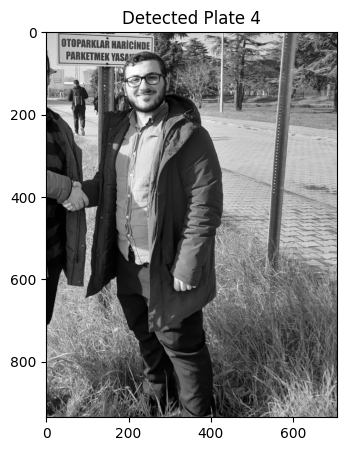

/var/folders/ps/w20y7l6s0czd7vj9t9xzwbbc0000gn/T/ipykernel_70343/197802723.py:166: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(plate, cmap="gray")


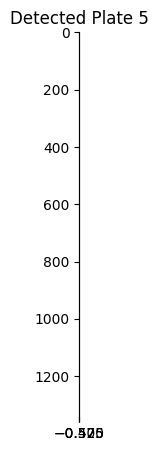

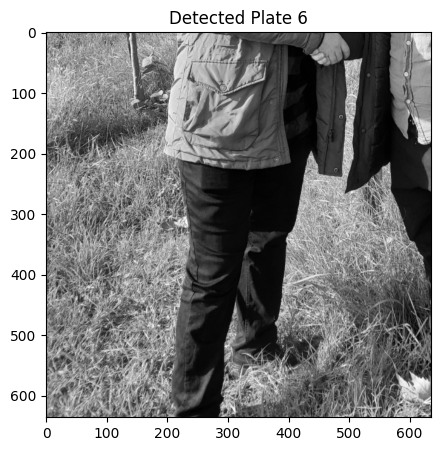

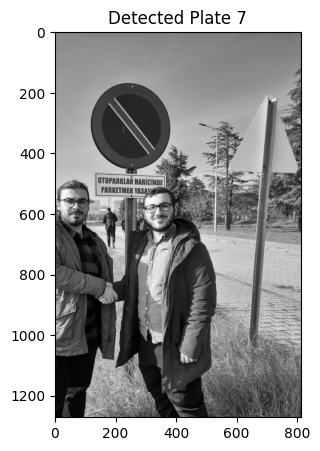

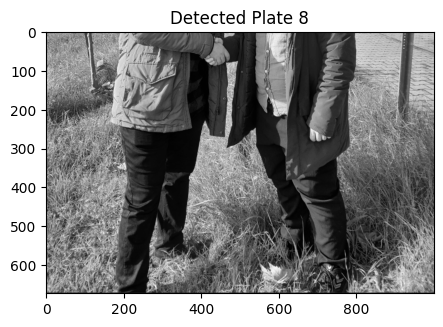

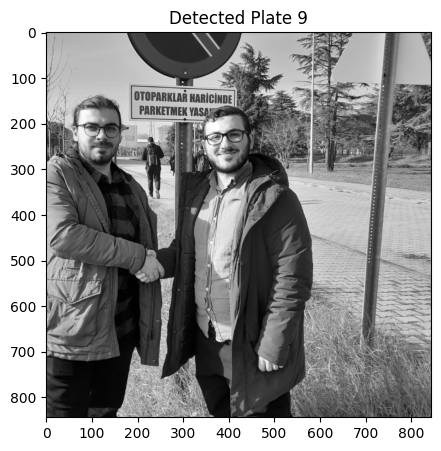

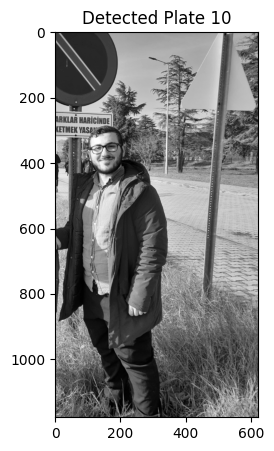

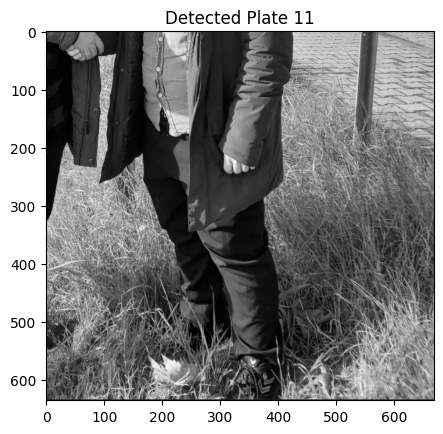

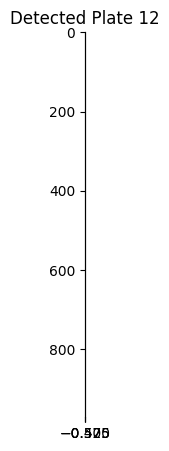

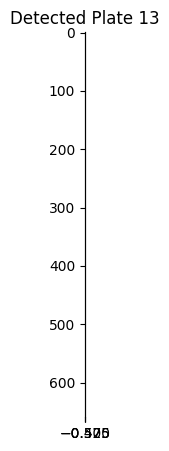

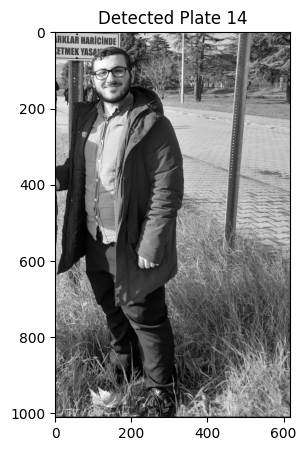

/var/folders/ps/w20y7l6s0czd7vj9t9xzwbbc0000gn/T/ipykernel_70343/197802723.py:166: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(plate, cmap="gray")


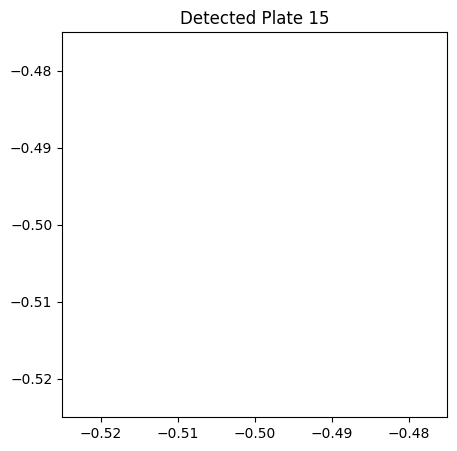

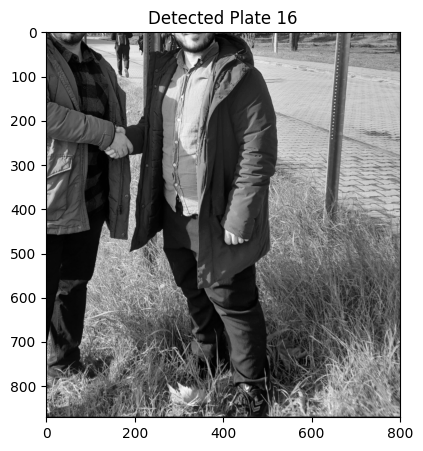

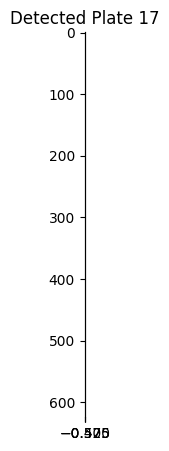

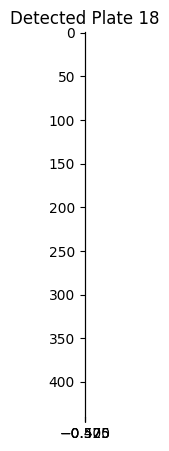

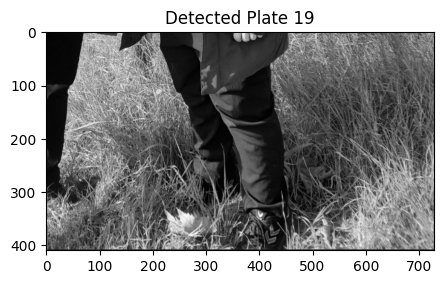

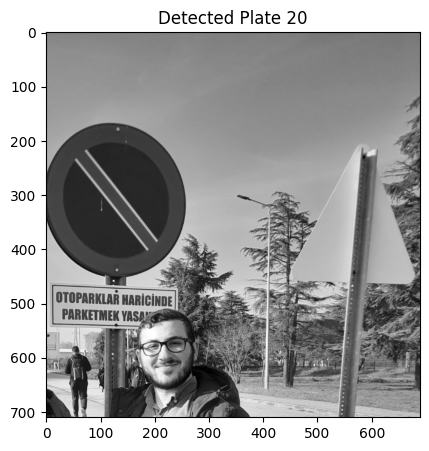

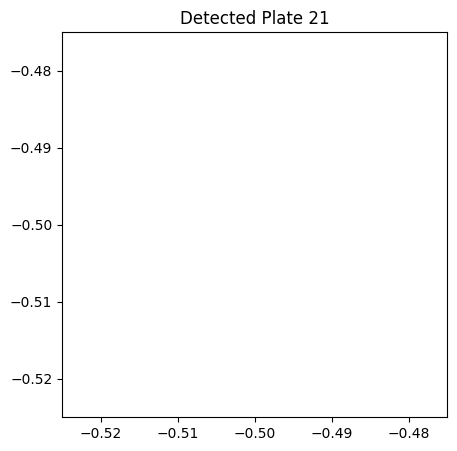

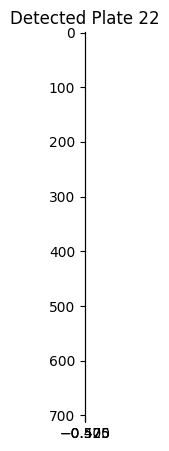

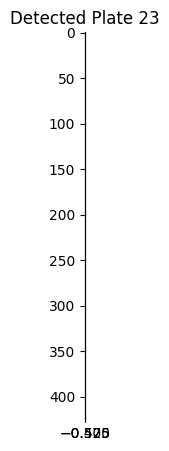

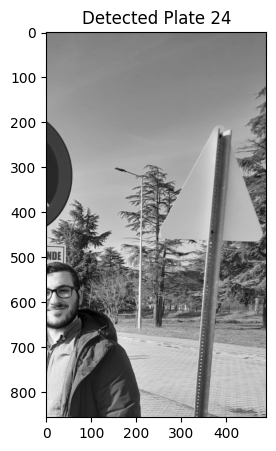

<Figure size 640x480 with 0 Axes>

In [2]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_hard_2.png")
detector.visualize_results()